In [1]:
import torch
from models.paddedgrid_vae import VAE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(
    in_channels=10, 
    num_filters=128, 
    latent_dim=64,
    l2_penalty=1e-5
).to(device)

checkpoint = torch.load('../../checkpoints/vae_checkpoint_1.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [2]:
import glob
import os
import json
import re

folder_path = "../../data/evaluation"
json_files = glob.glob(os.path.join(folder_path, "*.json"))

train_data = {}
test_data = {}

for file in json_files:
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
        puzzle_id = re.search(r"([\da-f]+)\.json$", file).group(1)

        train_data[puzzle_id] = data["train"]
        test_data[puzzle_id] = data["test"][0]

Dataset size after augmentation: 6 -> 6


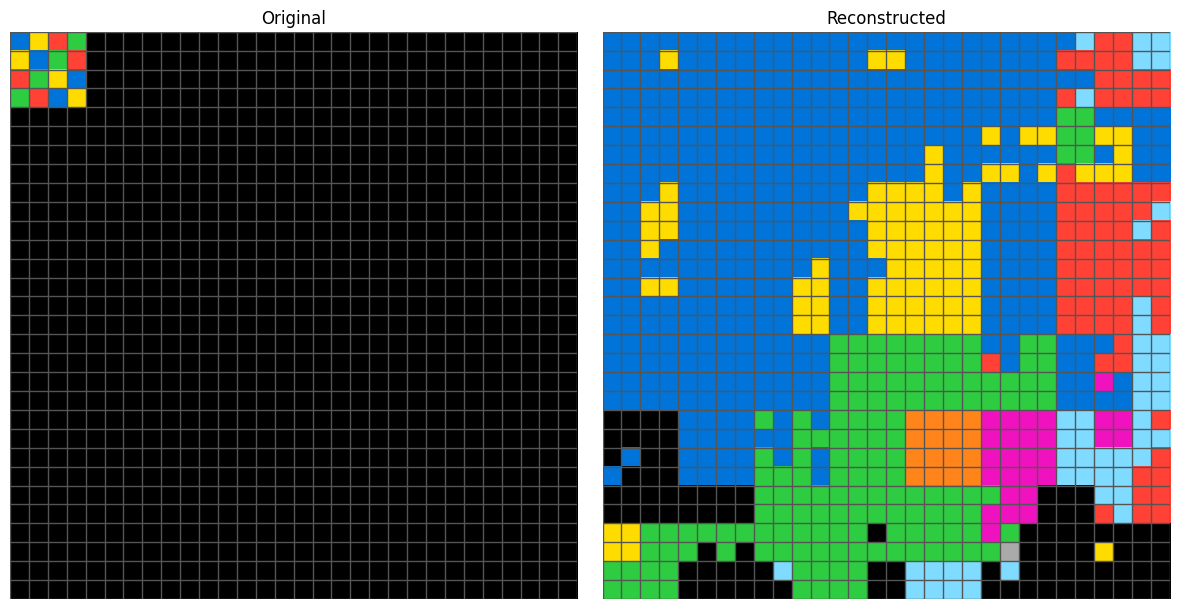

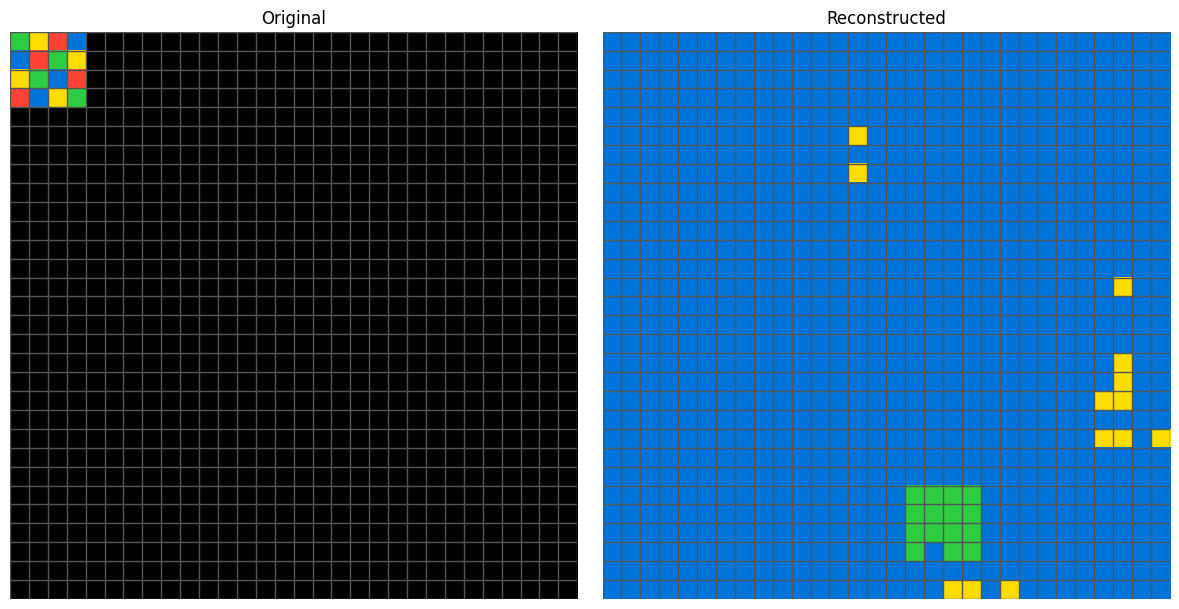

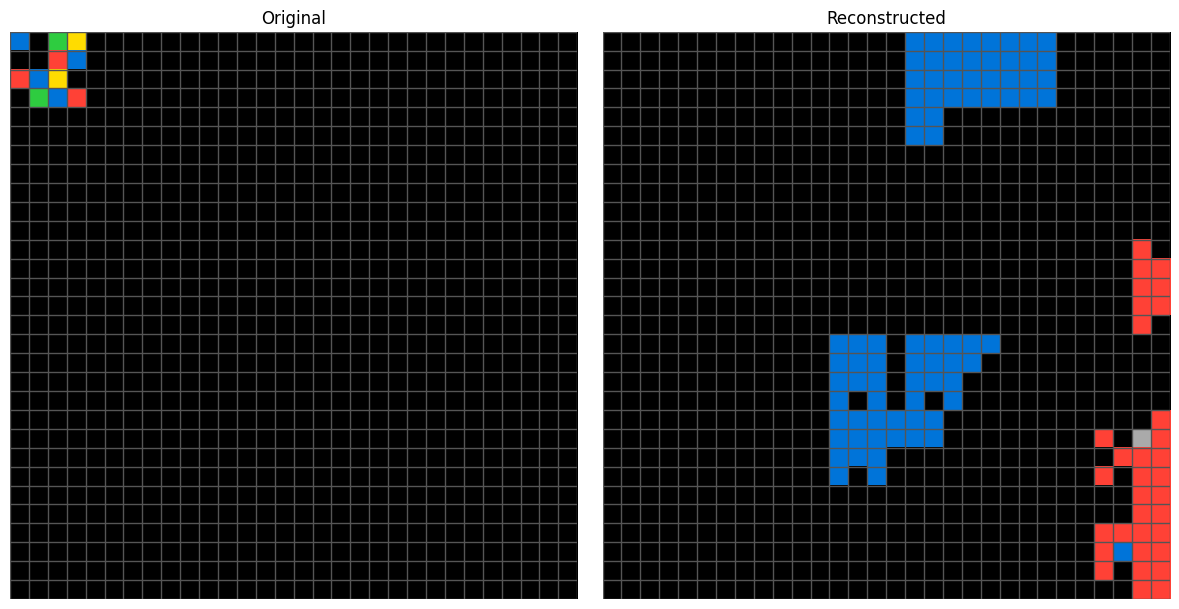

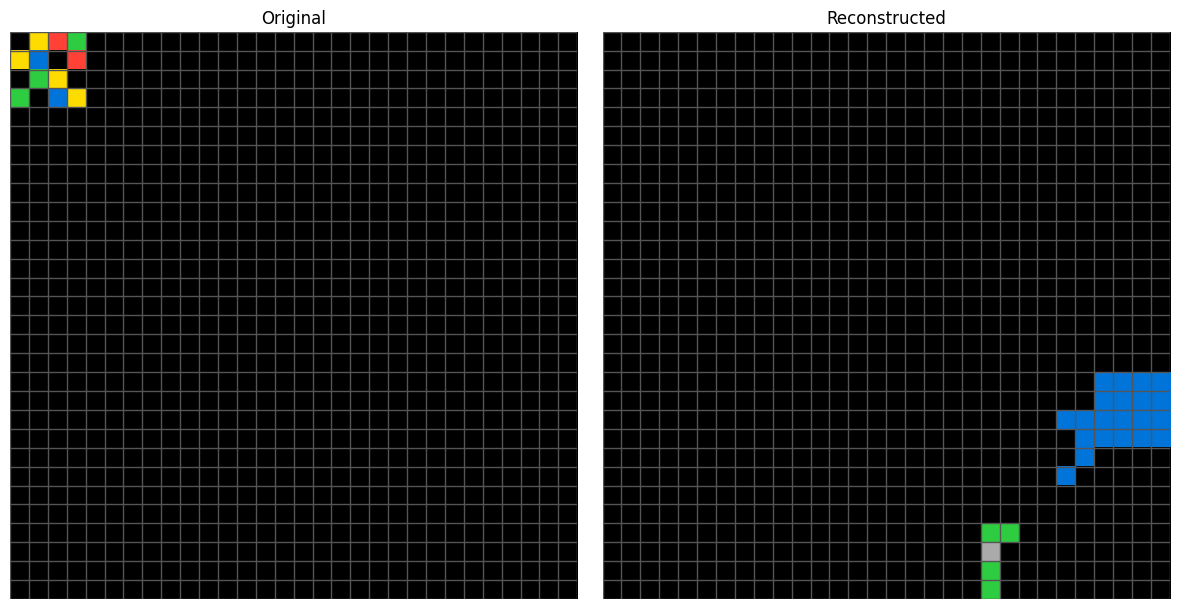

In [9]:
import random 
from utils.view import draw_grid, plot_task
from models.paddedgrid_vae import GridDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

random.seed(300)
key = random.choice(list(train_data.keys()))
#key='f9d67f8b'
#key='292dd178' 

# plot_task(key, train_data[key], test_data[key])
grids = [grid for item in train_data[key] for grid in item.values()]

dataset = GridDataset(grids, augment=False)
batch_size = len(grids)

test_loader = DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True, 
)

with torch.no_grad():
    test_batch, _ = next(iter(test_loader))
    test_batch = test_batch.to(device)
    # mask = mask.to(device)

    reconstructed = model.reconstruct(test_batch)
    
    for i in range(min(4, test_batch.size(0))):
        original = test_batch[i]
        # print(original)
        original = test_batch[i].argmax(axis=0).cpu().numpy()
        recon = reconstructed[i].cpu().numpy()
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
        draw_grid(axes[0], original, 'Original')
        draw_grid(axes[1], recon, 'Reconstructed')
        
        plt.tight_layout()
        plt.show()